## Import Necessary Libraries

In [1]:
import torch
import torch.nn as nn
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from IPython.display import Audio
import librosa
import seaborn as sns
import math
import numpy as np
import matplotlib.pyplot as plt
from pydub import AudioSegment
import os

from PreprocessAudio import PreprocessAudio

## Functions to Plot and Preprocess

In [2]:
def plot_waveform(waveform, sr, title="Waveform"):
    waveform = waveform.numpy()

    num_channels, num_frames = waveform.shape
    time_axis = torch.arange(0, num_frames) / sr

    figure, axes = plt.subplots(num_channels, 1)
    axes.plot(time_axis, waveform[0], linewidth=1)
    axes.grid(True)
    figure.suptitle(title)
    plt.show(block=False)


def plot_spectrogram(specgram, title=None, ylabel="freq_bin"):
    fig, axs = plt.subplots(1, 1)
    fig.set_figheight(4)
    fig.set_figwidth(8)
    axs.set_title(title)
    axs.set_ylabel(ylabel)
    axs.set_xlabel("frame")
    im = axs.imshow(librosa.power_to_db(specgram), origin="lower", aspect="auto", interpolation="nearest")
    fig.colorbar(im, ax=axs)
    plt.show(block=False)


def plot_fbank(fbank, title=None):
    fig, axs = plt.subplots(1, 1)
    axs.set_title(title or "Filter bank")
    axs.imshow(fbank, aspect="auto")
    axs.set_ylabel("frequency bin")
    axs.set_xlabel("mel bin")
    plt.show(block=False)
    
def conv2wav_torch(audio_dir, resample):
    mp3 = AudioSegment.from_mp3(audio_dir)
    wav = mp3.export(f'{audio_dir[:-4]}.wav', format="wav")
    waves, sr = torchaudio.load(f'{audio_dir[:-4]}.wav')
    waves = F.resample(waves, orig_freq=sr, new_freq=resample)
    return waves, resample

def vad_torch(waves, buff_size, threshold, display_info=False):
    mono_signal = waves[0].numpy()
    total_sig   = int(mono_signal.shape[0]/buff_size)
    signal      = []
    for i in range(total_sig):
        sig = mono_signal[i*buff_size:(i+1)*buff_size]
        rms = math.sqrt(np.square(sig).mean())
        if(rms > threshold):
            signal = np.append(signal,sig)
    signal = signal.astype('float')
    if (display_info):
        print("Number of total signal (signal_arr/buff_size):", total_sig)
        print("Signal data type:", signal.dtype)
        print(f"Signal shape: ({signal.shape})")
    return torch.tensor([signal])

## Load a Sample

In [3]:
waves, sr = conv2wav_torch('./cv_test.mp3', 8000)
signal_vad = vad_torch(waves, 1000, 0.012)

C:\Users\Kevin Putra Santoso\AppData\Local\Temp\ipykernel_2188\2708530823.py:55: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at C:\cb\pytorch_1000000000000\work\torch\csrc\utils\tensor_new.cpp:248.)
  return torch.tensor([signal])


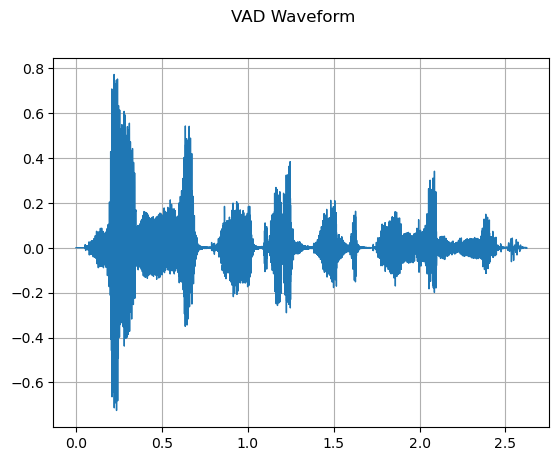

In [4]:
plot_waveform(signal_vad, sr, title="VAD Waveform")
Audio(signal_vad.numpy(), rate=sr)

In [5]:
speech_waveform = torchaudio.load('cv_test.wav')[0] # Sebelum dilakukan VAD

In [6]:
print(speech_waveform.shape)
print(signal_vad.shape) # Setelah dilakukan VAD, ukuran tensornya berubah

torch.Size([1, 269568])
torch.Size([1, 21000])


In [7]:
n_fft = 1024
win_length = None
hop_length = 128
n_mels = 64
n_mfcc = 64

mfcc_transform = T.MFCC(
    sample_rate=sr,
    n_mfcc=n_mfcc,
    melkwargs={
        "n_fft": n_fft,
        "n_mels": n_mels,
        "hop_length": hop_length,
        "mel_scale": "htk",
    },
)

mfcc = mfcc_transform(signal_vad.type(torch.float))

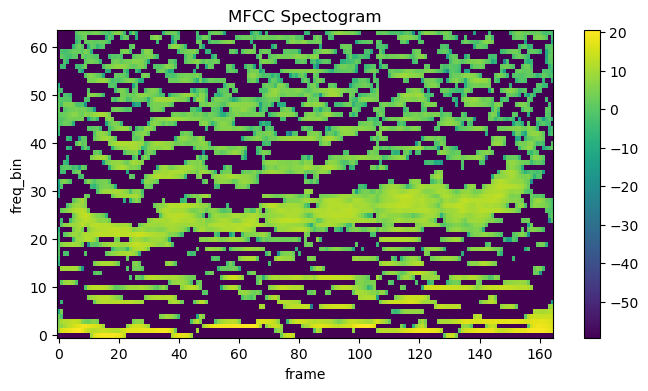

In [8]:
plot_spectrogram(mfcc[0], title="MFCC Spectogram")

In [9]:
mfcc[0].shape

torch.Size([64, 165])

## Load Metadata and Organize Audio Files

In [10]:
import pandas as pd
df = pd.read_csv('./common_voice_id/dev.tsv', sep='\t')

In [11]:
# df_copy = df.head(50).copy()
df = df[['path', 'sentence']]

In [12]:
df.head()

,path,sentence
0,common_voice_id_20952963.mp3,Saya ingin jalan-jalan ke semua tempat di Jepang.
1,common_voice_id_20952965.mp3,Anda berada dalam kondisi yang lebih baik dari...
2,common_voice_id_20952967.mp3,"Ketika keluar, saya lupa mematikan lampu."
3,common_voice_id_20952969.mp3,Saya meminjamkan buku tulis kepada Pak Kobayashi.
4,common_voice_id_20952974.mp3,Saya rindu Anda.


In [13]:
import string

def remove_strips(text):
    # Mengganti tanda hubung (-) dengan spasi dan menghapus tanda baca di awal dan akhir kata
    cleaned_text = text.replace('-', ' ').strip(string.punctuation)
    return cleaned_text

for i in range(len(df['sentence'])):
    # print(text)
    df['sentence'][i] = df['sentence'][i].lower()
    df['sentence'][i] = ' '.join(word.strip(string.punctuation) for word in df['sentence'][i].split())
    df['sentence'][i] = ' '.join(remove_strips(word) for word in df['sentence'][i].split())

In [14]:
df

,path,sentence
0,common_voice_id_20952963.mp3,saya ingin jalan jalan ke semua tempat di jepang
1,common_voice_id_20952965.mp3,anda berada dalam kondisi yang lebih baik dari...
2,common_voice_id_20952967.mp3,ketika keluar saya lupa mematikan lampu
3,common_voice_id_20952969.mp3,saya meminjamkan buku tulis kepada pak kobayashi
4,common_voice_id_20952974.mp3,saya rindu anda
...,...,...
3303,common_voice_id_21917972.mp3,banyak sekali planet sebesar jupiter di bima s...
3304,common_voice_id_33325171.mp3,sepertinya tom dan mary tidak benar benar ingi...
3305,common_voice_id_33325281.mp3,aku terkadang khawatir apakah akan ada kesulit...
3306,common_voice_id_33325512.mp3,dengan menentukan jam terbang


<b>Move Audio Files</b>

In [15]:
label_list = []
HOME = os.getcwd()
for i in range(len(df)):
    os.system(f'copy \"{HOME}\\common_voice_id\\clips\\{df["path"][i]}\" \"{HOME}\\audio_folder\\{df["path"][i]}\"')
    label_list.append(df['sentence'][i])

In [16]:
print(f'Banyaknya label: {len(label_list)}')
print('Sampel 10 label')
label_list[:10]

Banyaknya label: 3308
Sampel 10 label


['saya ingin jalan jalan ke semua tempat di jepang',
 'anda berada dalam kondisi yang lebih baik daripada aku',
 'ketika keluar saya lupa mematikan lampu',
 'saya meminjamkan buku tulis kepada pak kobayashi',
 'saya rindu anda',
 'saya menulis jawaban ujian dengan bolpoin',
 'tom mengemudi terlalu cepat',
 'ayah saya setiap hari bekerja dari pagi sampai malam',
 'saya belok kanan di belokan berikutnya',
 'apa kabar kabar saya baik terima kasih']

In [17]:
label_list_len = []
for text in label_list:
    label_list_len.append(len(text))

In [18]:
print(f'Teks terpanjang: {np.max(label_list_len)} karakter')
print(f'Indeks teks terpanjang: {np.argmax(label_list_len)}')

Teks terpanjang: 131 karakter
Indeks teks terpanjang: 2749


In [19]:
alphabet = 'abcdefghijklmnopqrstuvwxyz '
num_alpha = len(alphabet) + 1
num_timestamps = np.argmax(label_list_len) + 5
max_str_len = np.argmax(label_list_len) + 5

def conv2num(label):
    label_enc = []
    for i in label:
        label_enc.append(alphabet.find(i))
    return np.array(label_enc)

def num2label(num):
    txt = ""
    for i in num:
        if i == -1:
            break
        else:
            txt += alphabet[i]

In [20]:
print(label_list[0])
print(conv2num(label_list[0]))

saya ingin jalan jalan ke semua tempat di jepang
[18  0 24  0 26  8 13  6  8 13 26  9  0 11  0 13 26  9  0 11  0 13 26 10
  4 26 18  4 12 20  0 26 19  4 12 15  0 19 26  3  8 26  9  4 15  0 13  6]


In [21]:
train_size = len(label_list) # Bisa diganti
train_y = np.ones([train_size, max_str_len]) * -1
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_timestamps-2) # -2 bisa diganti2 juga
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(label_list[i])
    train_y[i, 0:len(label_list[i])]= conv2num(label_list[i])    

In [22]:
print(train_y[2749]) # Label terpanjang

[10.  0. 11. ... -1. -1. -1.]


In [23]:
Pipeline = PreprocessAudio('./audio_folder/')

In [24]:
dataset = Pipeline.load_audio()

Mounted audio directory at: ./audio_folder/
Error di file ./audio_folder/common_voice_id_21705364.mp3


**CATATAN**: Masih ada error ketika memproses sebuah audio. Penyebabnya sedang dicari.

In [ ]:
for i in range(30):
    print(torch.tensor(dataset[i][0]).shape)

In [39]:
torch.tensor(dataset[1][0]).shape

torch.Size([126, 64])

In [88]:
dataset_list = []
for i in range(len(dataset)):
    dataset_list.append(torch.tensor(dataset[i][0]))

In [89]:
max_timestep = max(data.shape[0] for data in dataset_list)

In [90]:
dataset_list[1].shape

torch.Size([126, 64])

In [118]:
# TRIAL
train_size = 10
vocab_size = 27
print(np.ones([train_size, 1]) * (vocab_size-2))
print(np.zeros([train_size]))

[[25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]
 [25.]]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [92]:
from torch.utils.data import DataLoader, TensorDataset

data_loader = DataLoader(dataset_list, batch_size=2, collate_fn=lambda x: nn.utils.rnn.pad_sequence(x, batch_first=True), shuffle=True)

In [55]:
data_loader

In [38]:
mfcc.T.shape

torch.Size([165, 64, 1])

## Model Architecture

In [94]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchinfo import summary

class BiLSTM(nn.Module):
    def __init__(self, input_size, num_layers, output_size):
        super(BiLSTM, self).__init__()
        self.input_size = input_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.lstm1 = nn.LSTM(input_size, 256, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(512, 256, batch_first=True, bidirectional=True)

        self.fc = nn.Linear(512, output_size)

    def forward(self, x):
        x, _ = self.lstm1(x)
        x, _ = self.lstm2(x)
        x = self.fc(x)
        x = F.softmax(x, dim=-1)

        return x

input_size = 64
num_layers = 128
num_of_characters = num_alpha

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = BiLSTM(input_size, num_layers, num_of_characters).to(device)

sample_input = torch.randn(150, 64).to(device)
summary(model, input_size=(150, 64))


Layer (type:depth-idx)                   Output Shape              Param #
BiLSTM                                   [150, 28]                 --
├─LSTM: 1-1                              [150, 512]                659,456
├─LSTM: 1-2                              [150, 512]                1,576,960
├─Linear: 1-3                            [150, 28]                 14,364
Total params: 2,250,780
Trainable params: 2,250,780
Non-trainable params: 0
Total mult-adds (G): 171.76
Input size (MB): 0.04
Forward/backward pass size (MB): 1.26
Params size (MB): 9.00
Estimated Total Size (MB): 10.30

## Model Training

In [ ]:
import torch.optim as optim

input_size = 64
hidden_size = 256
output_size = 28
num_epochs = 1

model = BiLSTM(input_size, hidden_size, output_size)
criterion = nn.CTCLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(num_epochs):
    optimizer.zero_grad()
    inputs = mfcc[0].T
    targets = text_arr
    outputs = model(inputs)
    input_lengths = torch.full(size=(inputs.size(0),), fill_value=inputs.size(1), dtype=torch.long)
    target_lengths = torch.full(size=(targets.size(0),), fill_value=targets.size(1), dtype=torch.long)
    loss = criterion(outputs, targets, input_lengths, target_lengths)
    loss.backward()
    optimizer.step()
    print('Epoch: {}, Loss: {}'.format(epoch+1, loss.item()))